# Examples 3: ISL Chapter 8 (James Hughes)

## Pre-Amble

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import ConfusionMatrixDisplay, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import Lasso, LogisticRegression

In [2]:
oj_df = pd.read_csv("OJ.csv").drop(columns=["Unnamed: 0"])

## Question 9

### Question 9.a.

In [3]:
oj_df.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [4]:
oj_df["Purchase"].value_counts()

Purchase
CH    653
MM    417
Name: count, dtype: int64

In [5]:
display(oj_df.describe(include=["int", "float"]))

,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000
mean,254.381308,3.959813,1.867421,2.085411,0.051860,0.123364,0.147664,0.161682,0.565782,1.962047,1.815561,0.146486,0.059298,0.027314,0.217991,1.630841
std,15.558286,2.308984,0.101970,0.134386,0.117474,0.213834,0.354932,0.368331,0.307843,0.252697,0.143384,0.271563,0.101760,0.062232,0.107535,1.430387
min,227.000000,1.000000,1.690000,1.690000,0.000000,0.000000,0.000000,0.000000,0.000011,1.190000,1.390000,-0.670000,0.000000,0.000000,0.000000,0.000000
25%,240.000000,2.000000,1.790000,1.990000,0.000000,0.000000,0.000000,0.000000,0.325257,1.690000,1.750000,0.000000,0.000000,0.000000,0.140000,0.000000
50%,257.000000,3.000000,1.860000,2.090000,0.000000,0.000000,0.000000,0.000000,0.600000,2.090000,1.860000,0.230000,0.000000,0.000000,0.240000,2.000000
75%,268.000000,7.000000,1.990000,2.180000,0.000000,0.230000,0.000000,0.000000,0.850873,2.130000,1.890000,0.320000,0.112676,0.000000,0.300000,3.000000
max,278.000000,7.000000,2.090000,2.290000,0.500000,0.800000,1.000000,1.000000,0.999947,2.290000,2.090000,0.640000,0.402010,0.252688,0.440000,4.000000


In [6]:
display(oj_df.describe(include=["object"]))

,Purchase,Store7
count,1070,1070
unique,2,2
top,CH,No
freq,653,714


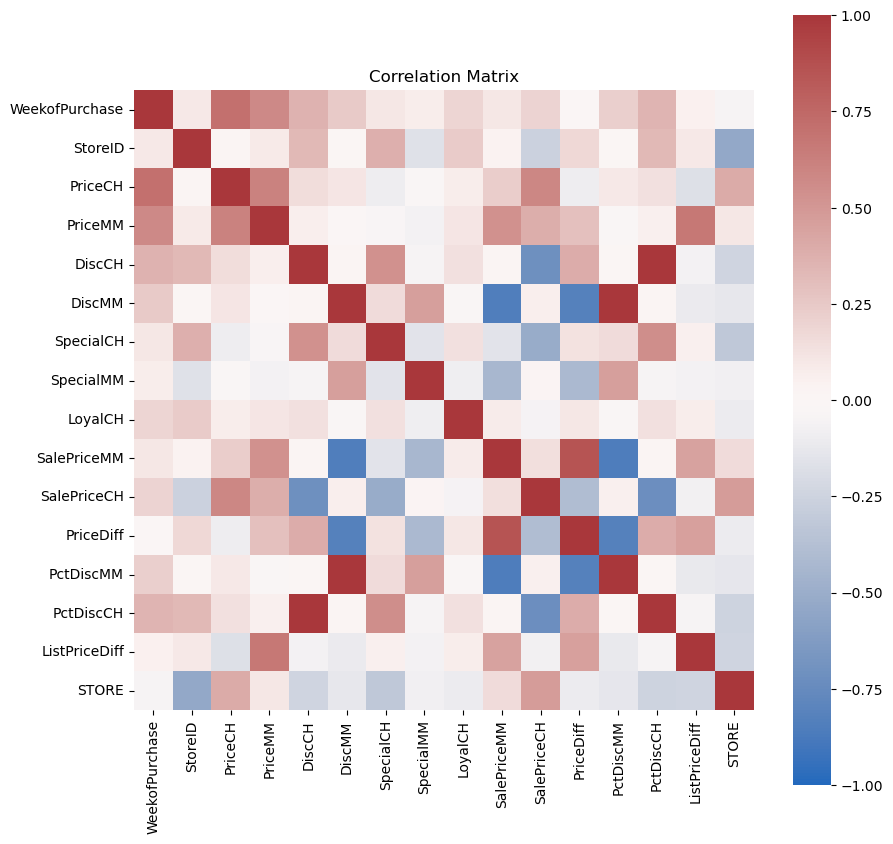

In [7]:
corr = oj_df.drop(columns=["Purchase", "Store7"]).corr()
fig = plt.figure(figsize=(10, 10))
_ = sns.heatmap(corr, square=True, cbar=True, cmap="vlag", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

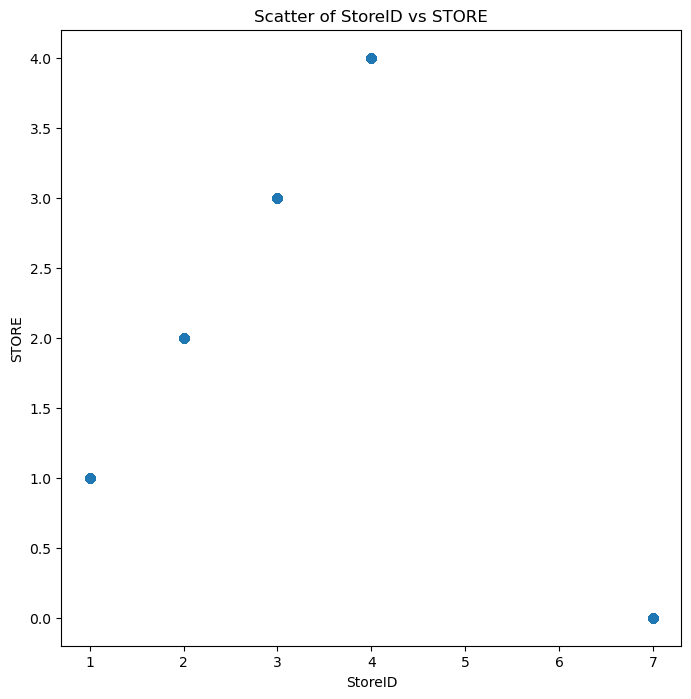

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.scatter(data=oj_df, x="StoreID", y="STORE")
ax.set(title="Scatter of StoreID vs STORE", xlabel="StoreID", ylabel="STORE")
plt.show()

From the exploratory analysis, we make some decisions in terms of preprocessing:
 - STORE is clearly a cleaned version of the StoreID variable, where intermediate values that did not appear are removed from the range. So we remove StoreID from the dataset.
 - STORE should be treated as a discrete variable, and thus deserves a one-hot encoding.
 - This one-hot encoding will also make the Store7 variable redundant, and thus we remove that too.
 - SalePriceMM, SalePriceCH, and PriceDiff are all correlated; we keep only the PriceDiff as the (most informative) representative. This also helps since the SalePrice variables are correlated with PctDisc variables.
 - The PctDisc variables are correlated with their corresponding Disc variables, hence we remove the later keeping the PctDisc variables as representatives.
 - Although the Special variables are discrete they are binary, so require no pre-processing.
 
(The link https://islp.readthedocs.io/en/latest/datasets/OJ.html was useful in helping to understand the variables and make these decisions.)

In [9]:
oj_df = oj_df.drop(columns=["StoreID", "DiscCH", "DiscMM", "SalePriceMM", "SalePriceCH", "Store7"])

In [10]:
ohe_STORE = pd.get_dummies(oj_df["STORE"], prefix="store", drop_first=False, dtype=int)
oj_df = oj_df.join(ohe_STORE).drop(columns=["STORE"])

X = np.array(oj_df.drop(columns=["Purchase"]))

In [11]:
label_ec_y = LabelEncoder()
y = label_ec_y.fit_transform(oj_df["Purchase"])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=800, random_state=42)

In [12]:
dt_reg = DecisionTreeClassifier(random_state=42)
dt_reg.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [13]:
print("Training error rate is: {:.5f}".format(1 - dt_reg.score(X_train, y_train)))

Training error rate is: 0.00750


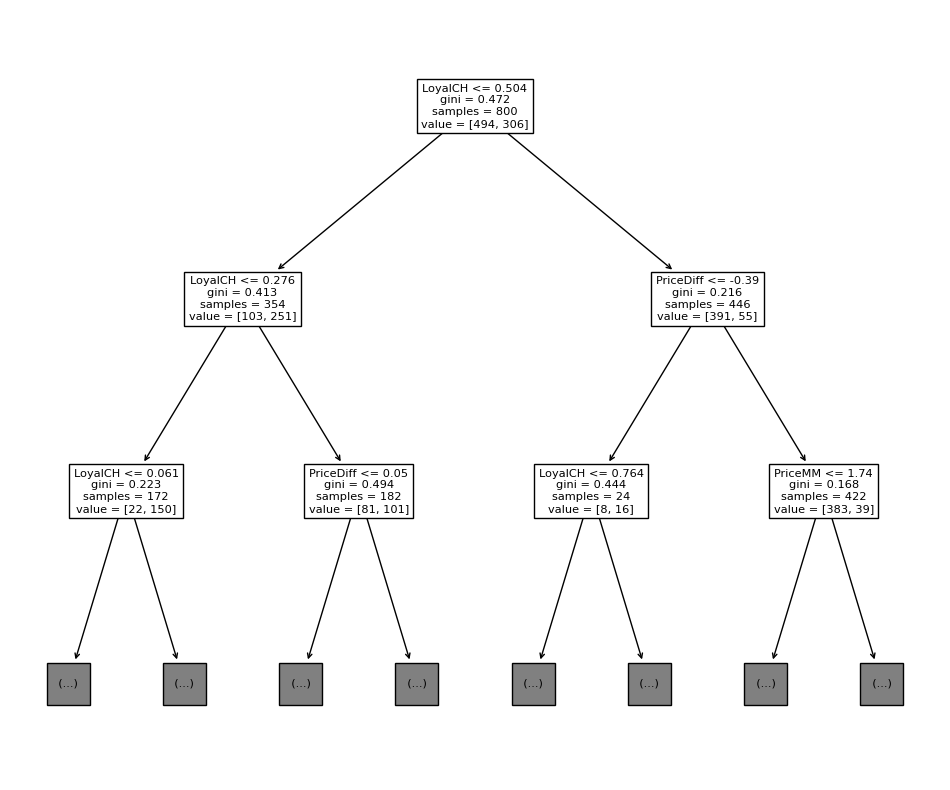

In [14]:
feature_names = list(oj_df.drop(columns=["Purchase"]).columns)
fig = plt.figure(figsize=(12, 10))
_ = plot_tree(dt_reg, max_depth=2, feature_names=feature_names)
plt.show()

In [15]:
print("Number of terminal nodes: {}".format(dt_reg.get_n_leaves()))

Number of terminal nodes: 167


In [16]:
print(export_text(dt_reg, feature_names=feature_names))

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- WeekofPurchase <= 268.50
|   |   |   |   |--- class: 1
|   |   |   |--- WeekofPurchase >  268.50
|   |   |   |   |--- PriceDiff <= 0.29
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- PriceDiff >  0.29
|   |   |   |   |   |--- class: 0
|   |   |--- LoyalCH >  0.06
|   |   |   |--- LoyalCH <= 0.21
|   |   |   |   |--- WeekofPurchase <= 273.00
|   |   |   |   |   |--- WeekofPurchase <= 261.00
|   |   |   |   |   |   |--- PriceDiff <= -0.13
|   |   |   |   |   |   |   |--- WeekofPurchase <= 240.00
|   |   |   |   |   |   |   |   |--- WeekofPurchase <= 236.50
|   |   |   |   |   |   |   |   |   |--- WeekofPurchase <= 234.00
|   |   |   |   |   |   |   |   |   |   |--- LoyalCH <= 0.16
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- LoyalCH >  0.16
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   

In [17]:
label_ec_y.classes_

array(['CH', 'MM'], dtype=object)

We see that the first terminal node corresponds to a prediction of class 1 if
 - LoyalCH <= 0.06
 - WeekofPurchase <= 268

In simpler terms, the tree predicts a purchase of a Minute Maid orange juice if the LoyalCH variable is low, and the purchase date was early (relative to the data from the dataset).

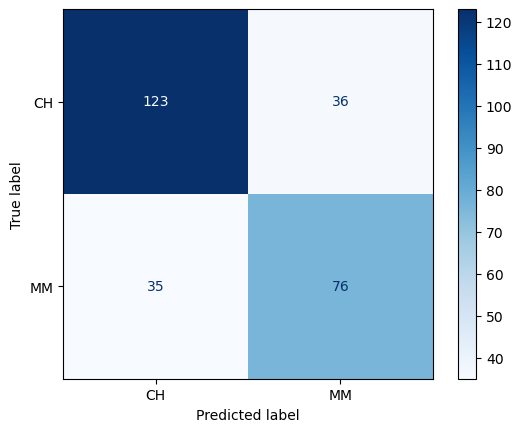

Test error rate: 0.26296


In [18]:
ConfusionMatrixDisplay.from_estimator(dt_reg, X_test, y_test, display_labels=label_ec_y.classes_, cmap=plt.cm.Blues)
plt.show()
print("Test error rate: {:.5f}".format(1 - dt_reg.score(X_test, y_test)))

### Question 9.f. Cross-Validation & Tuning

In [19]:
ccp_path = DecisionTreeClassifier().cost_complexity_pruning_path(X_train, y_train) 

In [20]:
np.log(0.0001+ccp_path.ccp_alphas)

array([-9.21034037, -7.79327435, -7.56811264, -7.56811264, -7.56811264,
       -7.23522058, -7.2293389 , -7.17345844, -7.11319925, -7.07027421,
       -7.0540664 , -7.02241819, -6.97674815, -6.87094131, -6.87094131,
       -6.87094131, -6.8124451 , -6.8124451 , -6.8124451 , -6.8124451 ,
       -6.7752661 , -6.7752661 , -6.76132665, -6.74953127, -6.74953127,
       -6.73065567, -6.70481443, -6.70481443, -6.6903424 , -6.68795063,
       -6.66726309, -6.66046127, -6.64890757, -6.62572138, -6.62527539,
       -6.62373734, -6.62156686, -6.60765069, -6.60765069, -6.55924327,
       -6.48342169, -6.47172752, -6.45630506, -6.43775165, -6.42298033,
       -6.38389004, -6.37241773, -6.36993958, -6.32543121, -6.28465194,
       -6.22718688, -6.19861276, -6.14949836, -6.14175904, -6.13896515,
       -6.12690252, -6.03115443, -6.02177579, -6.00157655, -5.87763995,
       -5.68147726, -5.62614674, -5.57642422, -5.52691029, -5.49676831,
       -5.49442584, -5.00604392, -4.97932393, -4.27222326, -3.97

In [21]:
ccp_path = DecisionTreeClassifier().cost_complexity_pruning_path(X_train, y_train) 

dt_cv = GridSearchCV(DecisionTreeClassifier(), param_grid={"ccp_alpha": np.unique(ccp_path.ccp_alphas)}, cv=5, refit=True)

dt_cv.fit(X_train, y_train)

dt_results = pd.DataFrame(dt_cv.cv_results_).drop(columns=["params"]).astype("float")

In [22]:
dt_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003962,0.000727,0.001696,0.000675,0.000000,0.76875,0.77500,0.80625,0.78125,0.76250,0.77875,0.015104,56.0
1,0.004635,0.001195,0.003110,0.002631,0.000417,0.77500,0.75000,0.80625,0.78125,0.78750,0.78000,0.018286,53.0
2,0.004682,0.000583,0.001607,0.000919,0.000417,0.78125,0.76875,0.80625,0.78750,0.78125,0.78500,0.012247,39.0
3,0.004765,0.001701,0.001339,0.000441,0.000621,0.76250,0.74375,0.81875,0.77500,0.75625,0.77125,0.025800,63.0
4,0.004795,0.001766,0.001613,0.000727,0.000625,0.76875,0.75000,0.80625,0.77500,0.75625,0.77125,0.019605,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.003325,0.001014,0.000749,0.000240,0.006779,0.81250,0.84375,0.82500,0.80625,0.85000,0.82750,0.017048,1.0
61,0.003029,0.000222,0.000993,0.000519,0.013851,0.80000,0.82500,0.84375,0.77500,0.85625,0.82000,0.029422,9.0
62,0.003983,0.000713,0.001374,0.000405,0.018721,0.80000,0.82500,0.83125,0.77500,0.80625,0.80750,0.019922,14.0
63,0.003061,0.000844,0.000620,0.000154,0.022236,0.78125,0.82500,0.83125,0.76875,0.80625,0.80250,0.024238,17.0


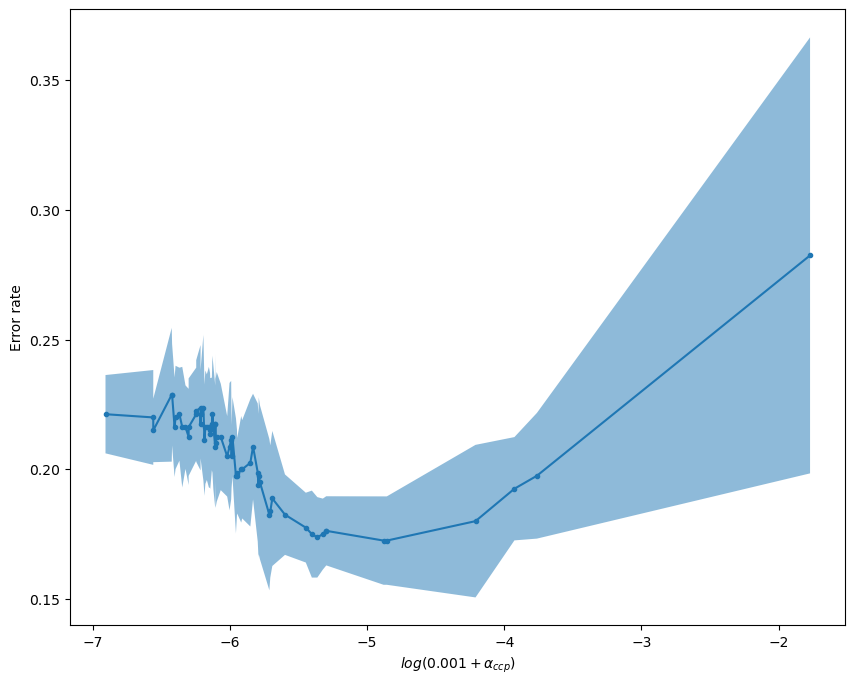

In [23]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

ax.plot(np.log(1e-3+dt_results["param_ccp_alpha"]), 1 - dt_results["mean_test_score"], marker=".")
ax.fill_between(np.log(1e-3+dt_results["param_ccp_alpha"]), 1 - dt_results["mean_test_score"] + dt_results["std_test_score"],
                1 - dt_results["mean_test_score"] - dt_results["std_test_score"], alpha=.5)
ax.set_xlabel(r"$log(0.001 + \alpha_{ccp}$)")
ax.set_ylabel("Error rate")

plt.show()

In [24]:
dt_reg_best = dt_cv.best_estimator_

The optimal alpha is: 0.006597
This leads to number of leaf nodes: 6
The pruned tree train error rate is 0.19259
The pruned tree test error rate is 0.15625


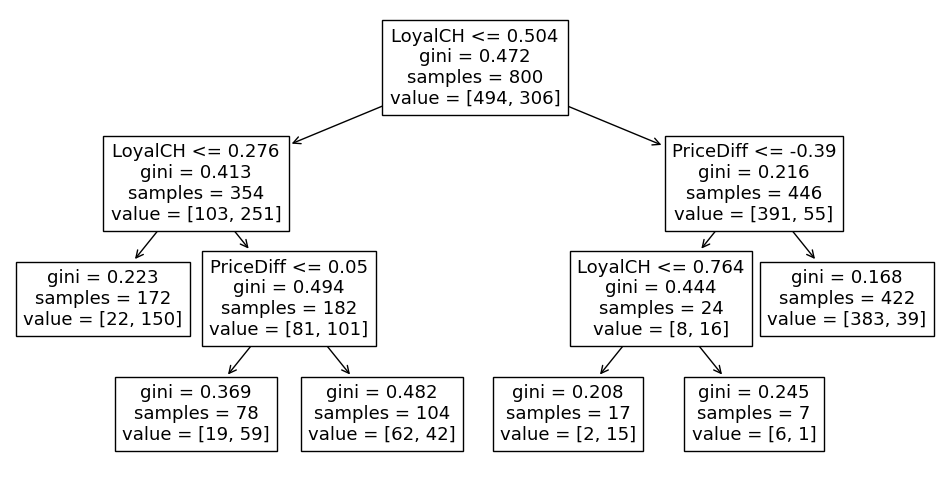

In [25]:
print("The optimal alpha is: {:.6f}".format(dt_reg_best.ccp_alpha))
print("This leads to number of leaf nodes: {}".format(dt_reg_best.get_n_leaves()))
print("The pruned tree train error rate is {:.5f}".format(1 - dt_reg_best.score(X_test, y_test)))
print("The pruned tree test error rate is {:.5f}".format(1 - dt_reg_best.score(X_train, y_train)))

fig = plt.figure(figsize=(12, 6))
_ = plot_tree(dt_reg_best, max_depth=4, feature_names=feature_names)
plt.show()

We can see that in the case of the unpruned tree, the train error rate is 0.008, but this jumps to 0.263 when assessed on the test data. On the other hand, the pruned tree performs worse on the training data with error rate of 0.193, but this actually improves when assesed on the test data to 0.156, which is much better than the unpruned tree. This is a clear demonstration of the fact that we have avoided overfitting to the data by introducing a complexity penalty into the cost function with which we train the decision tree classifier. In other words, we have sacrificed having a worse bias, in order to have a lower variance model, i.e. one which generalises better to unseen data.

## Question 10

### Question 10.a.

In [26]:
hitters_df = pd.read_csv("Hitters.csv")

In [27]:
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [28]:
display(hitters_df.describe(include=[int, float]))

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,263.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,535.925882
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,451.118681
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,190.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,425.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000


In [29]:
display(hitters_df.describe(include=["object"]))

,League,Division,NewLeague
count,322,322,322
unique,2,2,2
top,A,W,A
freq,175,165,176


In [30]:
hitters_df = hitters_df.dropna(axis=0)
hitters_df["Salary"] = np.log(hitters_df["Salary"])

In [31]:
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,6.163315,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,6.173786,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,6.214608,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,4.516339,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,6.620073,A


In [32]:
(hitters_df["League"] == hitters_df["NewLeague"]) .sum() / len(hitters_df)

0.9315589353612167

Based on the similarity of the two league features, and the fact that the NewLeague could potentially leak information about the target variable (https://islp.readthedocs.io/en/latest/datasets/Hitters.html) we decide to remove the NewLeague variable, and one-hot encode the remaining two categorical features. We have ignored the correlations of the discrete variables, but could revisit this if we find that our model performs poorly later on.

In [33]:
ohe_League = pd.get_dummies(hitters_df["League"], prefix="League", drop_first=False, dtype=int)
ohe_Division = pd.get_dummies(hitters_df["Division"], prefix="Division", drop_first=False, dtype=int)

hitters_df = hitters_df.join(ohe_League).drop(columns=["League", "NewLeague"])
hitters_df = hitters_df.join(ohe_Division).drop(columns=["Division"])

In [34]:
hitters_df.head(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W
1,315,81,7,24,38,39,14,3449,835,69,...,414,375,632,43,10,6.163315,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,266,263,880,82,14,6.173786,1,0,0,1


In [35]:
X = np.array(hitters_df.drop(columns=["Salary"]))
y = np.array(hitters_df["Salary"])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=200, random_state=42)

In [36]:
np.logspace(-2,5,8)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])

In [37]:
gb_reg = GradientBoostingRegressor(random_state=42)
gb_cv = GridSearchCV(gb_reg, param_grid={"learning_rate": np.logspace(-2,0,20)}, cv=5, scoring="neg_mean_squared_error")
gb_cv.fit(X_train, y_train)
gb_results = pd.DataFrame(gb_cv.cv_results_).drop(columns=["params"]).astype("float")

In [38]:
gb_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.205744,0.015571,0.003073,0.002637,0.010000,-0.372967,-0.272529,-0.217590,-0.237343,-0.281998,-0.276485,0.053583,18.0
1,0.218589,0.016511,0.001310,0.000294,0.012743,-0.340840,-0.232248,-0.185545,-0.202515,-0.253073,-0.242844,0.054277,16.0
2,0.187967,0.071420,0.003107,0.004292,0.016238,-0.326447,-0.203273,-0.157663,-0.176543,-0.234348,-0.219655,0.059313,14.0
3,0.114724,0.012713,0.000912,0.000430,0.020691,-0.323787,-0.183049,-0.136377,-0.158459,-0.227848,-0.205904,0.066310,12.0
4,0.133838,0.017807,0.000823,0.000242,0.026367,-0.321954,-0.173472,-0.123128,-0.149707,-0.216039,-0.196860,0.069603,7.0
5,0.108169,0.005235,0.001228,0.000968,0.033598,-0.325768,-0.172677,-0.115852,-0.149608,-0.217287,-0.196238,0.072681,6.0
6,0.109209,0.007236,0.001101,0.000681,0.042813,-0.319378,-0.166335,-0.112663,-0.142414,-0.229790,-0.194116,0.073542,3.0
7,0.142606,0.021865,0.001678,0.001015,0.054556,-0.318801,-0.167176,-0.116400,-0.155323,-0.212712,-0.194083,0.069516,2.0
8,0.112347,0.010157,0.000906,0.000390,0.069519,-0.317679,-0.167844,-0.116330,-0.147948,-0.222754,-0.194511,0.070653,5.0
9,0.119831,0.015208,0.001211,0.000658,0.088587,-0.322526,-0.175193,-0.115728,-0.146353,-0.212386,-0.194437,0.071563,4.0


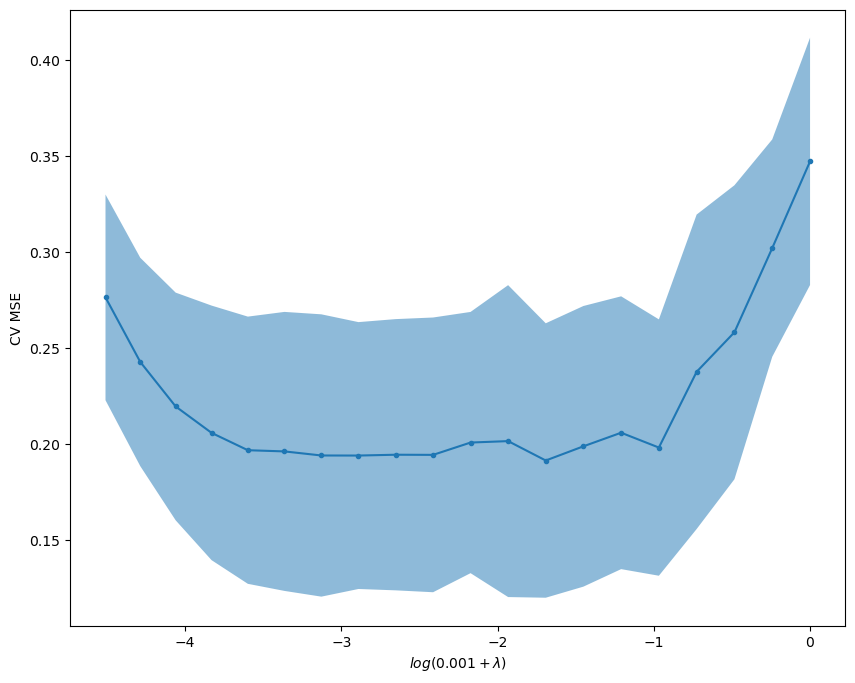

In [39]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

ax.plot(np.log(1e-3+gb_results["param_learning_rate"]), - gb_results["mean_test_score"], marker=".")
ax.fill_between(np.log(1e-3+gb_results["param_learning_rate"]), - gb_results["mean_test_score"] + gb_results["std_test_score"],
                - gb_results["mean_test_score"] - gb_results["std_test_score"], alpha=.5)
ax.set_xlabel(r"$log(0.001 + \lambda$)")
ax.set_ylabel("CV MSE")

plt.show()

In [40]:
gb_reg_best = gb_cv.best_estimator_
print("Best regressor had shrinkage parameter {:.5f} with CV MSE {:.5f}.".format(gb_cv.best_params_["learning_rate"], - gb_cv.best_score_))
print("The best test MSE was {:.5f}".format(mean_squared_error(gb_reg_best.predict(X_test), y_test)))

Best regressor had shrinkage parameter 0.18330 with CV MSE 0.19150.
The best test MSE was 0.27012


### Question 10. e-g. Other Models

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
lasso_reg = Lasso(random_state=42)
lasso_cv = GridSearchCV(lasso_reg, param_grid={"alpha": np.logspace(-3,3,7)}, cv=5, scoring="neg_mean_squared_error")
lasso_cv.fit(X_train_scaled, y_train)

lasso_results = pd.DataFrame(lasso_cv.cv_results_).drop(columns=["params"]).astype(float)
display(lasso_results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008275,0.003074,0.002855,0.002975,0.001,-0.541674,-0.446047,-0.270702,-0.376289,-0.475303,-0.422003,0.092436,3.0
1,0.006569,0.004318,0.004112,0.004421,0.010,-0.507795,-0.454593,-0.265045,-0.351706,-0.421293,-0.400086,0.084379,1.0
2,0.004230,0.001954,0.002831,0.001187,0.100,-0.532010,-0.499304,-0.302383,-0.373791,-0.371571,-0.415812,0.086095,2.0
3,0.002948,0.000674,0.001864,0.001263,1.000,-1.013226,-0.874757,-0.734239,-0.852244,-0.671367,-0.829167,0.118660,4.0
4,0.002937,0.001401,0.001397,0.000925,10.000,-1.013226,-0.874757,-0.734239,-0.852244,-0.671367,-0.829167,0.118660,4.0
5,0.002348,0.001467,0.001791,0.001715,100.000,-1.013226,-0.874757,-0.734239,-0.852244,-0.671367,-0.829167,0.118660,4.0
6,0.003368,0.001380,0.001844,0.000417,1000.000,-1.013226,-0.874757,-0.734239,-0.852244,-0.671367,-0.829167,0.118660,4.0


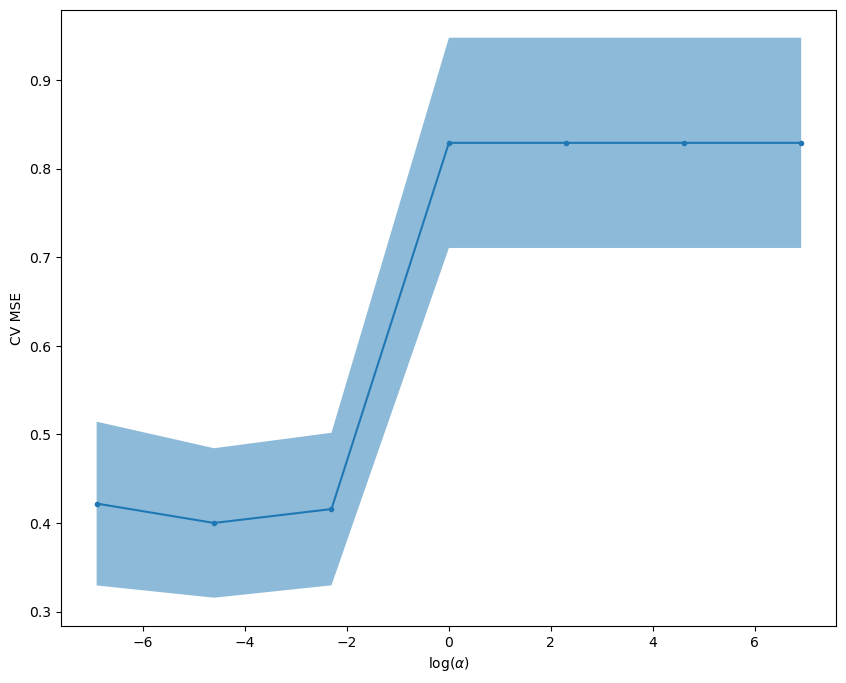

In [43]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

ax.plot(np.log(lasso_results["param_alpha"]), - lasso_results["mean_test_score"], marker=".")
ax.fill_between(np.log(lasso_results["param_alpha"]), - lasso_results["mean_test_score"] + lasso_results["std_test_score"],
                - lasso_results["mean_test_score"] - lasso_results["std_test_score"], alpha=.5)
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("CV MSE")

plt.show()

In [44]:
print("Best regressor had shrinkage parameter {:.5f} with CV MSE {:.5f}.".format(lasso_cv.best_params_["alpha"], - lasso_cv.best_score_))
print("The best test MSE was {:.5f}".format(mean_squared_error(lasso_cv.best_estimator_.predict(X_test), y_test)))

Best regressor had shrinkage parameter 0.01000 with CV MSE 0.40009.
The best test MSE was 20970.17281


This performs considerably worse than the Boosting model, with a CV MSE which is almost double compared to the best GradientBoost decision tree regressor, and the model clearly doesn't generalise well (which makes sense, as there may be some linear trends being extrapolated).

In [45]:
feature_df = pd.DataFrame({
    "Feature": hitters_df.drop(columns=["Salary"]).columns,
    "Feature Importance": gb_reg_best.feature_importances_,
    "Lasso Coef": lasso_cv.best_estimator_.coef_,
})
feature_df.sort_values(by="Feature Importance", ascending=False)

,Feature,Feature Importance,Lasso Coef
10,CRuns,0.298548,0.069268
7,CAtBat,0.225237,0.000000
8,CHits,0.171396,0.059015
11,CRBI,0.065007,0.000000
0,AtBat,0.037312,-0.000000
9,CHmRun,0.033185,0.000000
12,CWalks,0.028006,-0.000000
1,Hits,0.027581,0.312905
13,PutOuts,0.024836,0.065675
6,Years,0.023207,0.345816


We can see that the boosting model places the greatest importance on the CRuns and CAtBat variables.

### Question 10.f. Bagging

In [46]:
bag_reg = BaggingRegressor(random_state=42)
bag_cv = GridSearchCV(bag_reg, param_grid={"n_estimators": [1,10,100,1000]}, cv=5, scoring="neg_mean_squared_error")
bag_cv.fit(X_train, y_train)
bag_results = pd.DataFrame(bag_cv.cv_results_).drop(columns=["params"]).astype("float")

In [47]:
bag_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010625,0.004533,0.002357,0.000803,1.0,-0.443313,-0.262541,-0.218990,-0.264053,-0.544658,-0.346711,0.125495,4.0
1,0.051023,0.013011,0.004206,0.001110,10.0,-0.303036,-0.182295,-0.154716,-0.166681,-0.300519,-0.221449,0.066173,3.0
2,0.423185,0.080652,0.015717,0.004161,100.0,-0.328990,-0.146022,-0.118327,-0.163053,-0.237290,-0.198736,0.076119,2.0
3,2.805619,0.181678,0.117950,0.008143,1000.0,-0.327663,-0.141909,-0.111157,-0.161351,-0.225274,-0.193471,0.076792,1.0


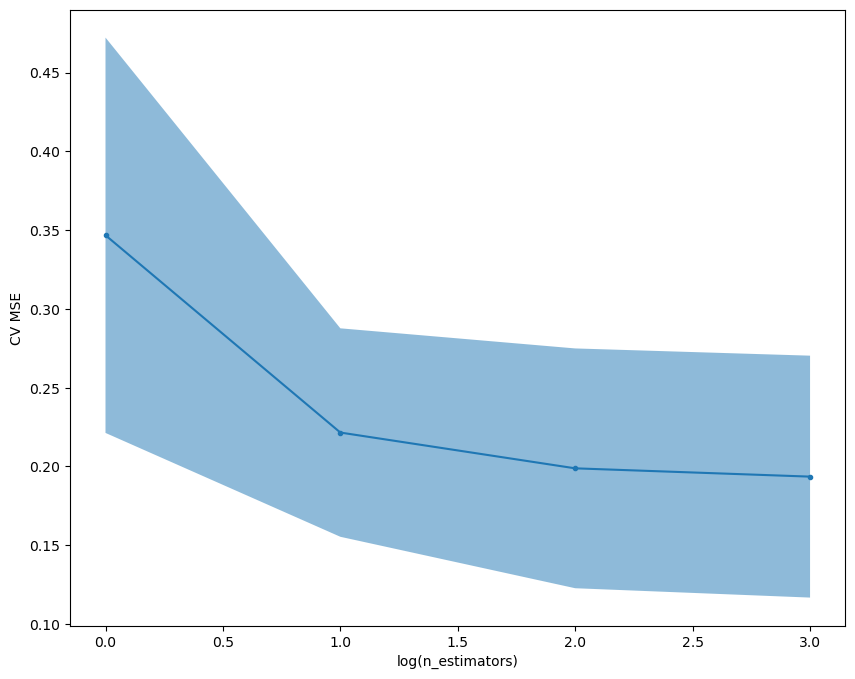

In [48]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

ax.plot(np.log10(bag_results["param_n_estimators"]), - bag_results["mean_test_score"], marker=".")
ax.fill_between(np.log10(bag_results["param_n_estimators"]), - bag_results["mean_test_score"] + bag_results["std_test_score"],
                - bag_results["mean_test_score"] - bag_results["std_test_score"], alpha=.5)
ax.set_xlabel(r"log(n_estimators)")
ax.set_ylabel("CV MSE")

plt.show()

In [49]:
bag_reg_best = bag_cv.best_estimator_
print("Best regressor had {:.5f} estimators with CV MSE {:.5f}.".format(bag_cv.best_params_["n_estimators"], - bag_cv.best_score_))
print("The best test MSE was {:.5f}".format(mean_squared_error(bag_reg_best.predict(X_test), y_test)))

Best regressor had 1000.00000 estimators with CV MSE 0.19347.
The best test MSE was 0.27024


## Question 12

I downloaded this dataset: https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones?select=test.csv

In short, the hundreds of features all correspond to sensor data from a person's smartphone whilst they perform some basic physical activity - the task is then to predict this activity from the sensor data.

In [50]:
activity_test_df = pd.read_csv("activity_test.csv").drop(columns=["subject"])
activity_train_df = pd.read_csv("activity_train.csv").drop(columns=["subject"])
activity_train_df

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819,WALKING_UPSTAIRS
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053,WALKING_UPSTAIRS
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811,WALKING_UPSTAIRS
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339,WALKING_UPSTAIRS


In [51]:
display(activity_train_df.describe(include=["float", "int"]))
display(activity_train_df.describe(include=["object"]))

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


,Activity
count,7352
unique,6
top,LAYING
freq,1407


In [52]:
label_ec_y = LabelEncoder()
label_ec_y.fit(activity_train_df["Activity"])

X_train = np.array(activity_train_df.drop(columns=["Activity"]))
y_train = label_ec_y.transform(activity_train_df["Activity"])

X_test = np.array(activity_test_df.drop(columns=["Activity"]))
y_test = label_ec_y.transform(activity_test_df["Activity"])

In [53]:
label_ec_y.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

### 12.a. Boosting

In [54]:
gb_clf = GradientBoostingClassifier(random_state=42, max_features="log2", n_estimators=10)
gb_cv = GridSearchCV(gb_clf, param_grid={"learning_rate": [0.01, 0.1, 1.0]}, cv=5)
gb_cv.fit(X_train, y_train)
gb_results = pd.DataFrame(gb_cv.cv_results_).drop(columns=["params"]).astype("float")

In [55]:
gb_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.676511,0.084896,0.005185,0.001467,0.01,0.738953,0.821890,0.808844,0.771429,0.809524,0.790128,0.030672,3.0
1,1.494101,0.026833,0.005081,0.001587,0.10,0.821210,0.874915,0.880952,0.831973,0.900000,0.861810,0.030117,2.0
2,1.755457,0.088155,0.006966,0.001889,1.00,0.855880,0.849082,0.892517,0.855782,0.925850,0.875822,0.029312,1.0


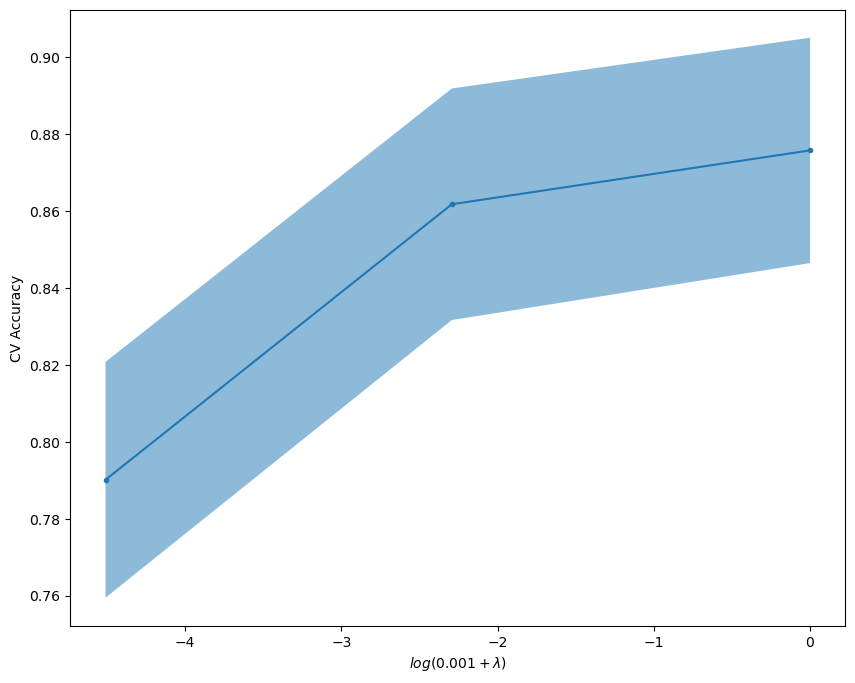

In [56]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

ax.plot(np.log(1e-3+gb_results["param_learning_rate"]), gb_results["mean_test_score"], marker=".")
ax.fill_between(np.log(1e-3+gb_results["param_learning_rate"]), gb_results["mean_test_score"] - gb_results["std_test_score"],
                gb_results["mean_test_score"] + gb_results["std_test_score"], alpha=.5)
ax.set_xlabel(r"$log(0.001 + \lambda$)")
ax.set_ylabel("CV Accuracy")

plt.show()

In [57]:
gb_clf_best = gb_cv.best_estimator_
print("Best regressor had shrinkage parameter {:.5f} with CV accuracy {:.5f}.".format(gb_cv.best_params_["learning_rate"], gb_cv.best_score_))
print("The best test accuracy was {:.5f}".format(gb_clf_best.score(X_test, y_test)))

Best regressor had shrinkage parameter 1.00000 with CV accuracy 0.87582.
The best test accuracy was 0.87547


### 12.b. Bagging

In [58]:
bag_clf = BaggingClassifier(random_state=42)
bag_cv = GridSearchCV(gb_clf, param_grid={"n_estimators": [5, 10, 15, 20]}, cv=5)
bag_cv.fit(X_train, y_train)
bag_results = pd.DataFrame(bag_cv.cv_results_).drop(columns=["params"]).astype("float")

In [59]:
bag_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.883361,0.088574,0.006616,0.005860,5.0,0.772944,0.814412,0.860544,0.782993,0.875510,0.821281,0.040822,4.0
1,1.647801,0.077943,0.005542,0.000936,10.0,0.821210,0.874915,0.880952,0.831973,0.900000,0.861810,0.030117,3.0
2,2.699792,0.259206,0.007038,0.001874,15.0,0.845683,0.891910,0.887075,0.872789,0.918367,0.883165,0.023847,2.0
3,3.491833,0.229275,0.006499,0.001817,20.0,0.858600,0.898708,0.893197,0.900000,0.923810,0.894863,0.020961,1.0


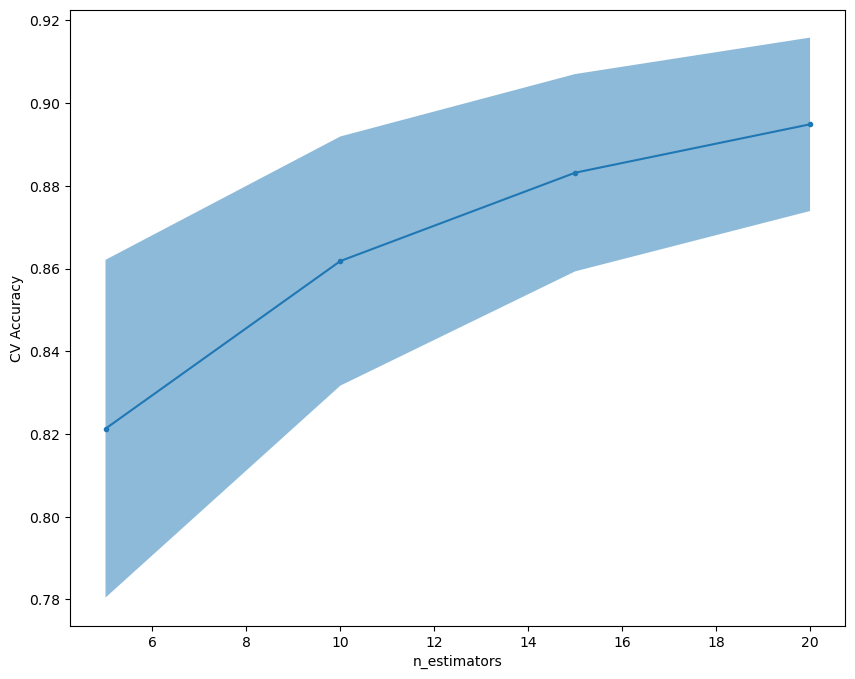

In [60]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

ax.plot(bag_results["param_n_estimators"], bag_results["mean_test_score"], marker=".")
ax.fill_between(bag_results["param_n_estimators"], bag_results["mean_test_score"] - bag_results["std_test_score"],
                bag_results["mean_test_score"] + bag_results["std_test_score"], alpha=.5)
ax.set_xlabel("n_estimators")
ax.set_ylabel("CV Accuracy")

plt.show()

In [61]:
bag_clf_best = bag_cv.best_estimator_
print("Best regressor had n_estimators {} with CV accuracy {:.5f}.".format(bag_cv.best_params_["n_estimators"], bag_cv.best_score_))
print("The best test accuracy was {:.5f}".format(bag_clf_best.score(X_test, y_test)))

Best regressor had n_estimators 20 with CV accuracy 0.89486.
The best test accuracy was 0.89175


### 12.c. Random Forest

In [62]:
rf_clf = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(rf_clf, param_grid={"n_estimators": [5, 10, 15, 20, 25]}, cv=5)
rf_cv.fit(X_train, y_train)
rf_results = pd.DataFrame(rf_cv.cv_results_).drop(columns=["params"]).astype("float")

In [63]:
rf_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.776180,0.118364,0.007131,0.002965,5.0,0.874915,0.875595,0.874150,0.880272,0.923129,0.885612,0.018880,5.0
1,1.422821,0.080123,0.008752,0.002484,10.0,0.900068,0.877634,0.896599,0.893197,0.932653,0.900030,0.018024,4.0
2,2.063116,0.144521,0.009582,0.003074,15.0,0.900068,0.885112,0.889116,0.899320,0.932653,0.901254,0.016727,3.0
3,2.560713,0.247722,0.013056,0.002194,20.0,0.900748,0.879674,0.894558,0.908844,0.934694,0.903703,0.018202,2.0
4,2.879795,0.055107,0.011821,0.000869,25.0,0.902107,0.893270,0.890476,0.914286,0.938095,0.907647,0.017340,1.0


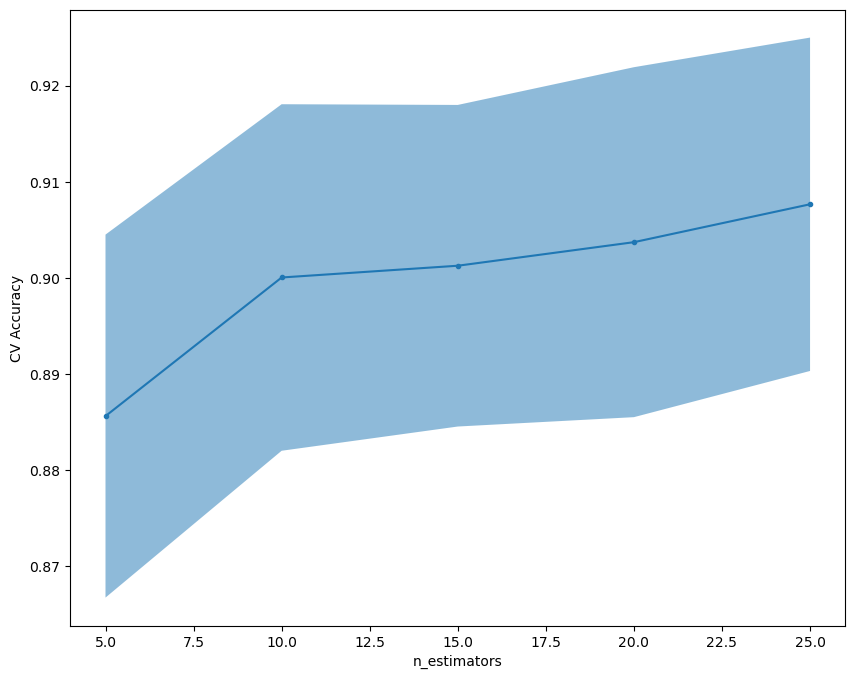

In [64]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

ax.plot(rf_results["param_n_estimators"], rf_results["mean_test_score"], marker=".")
ax.fill_between(rf_results["param_n_estimators"], rf_results["mean_test_score"] - rf_results["std_test_score"],
                rf_results["mean_test_score"] + rf_results["std_test_score"], alpha=.5)
ax.set_xlabel("n_estimators")
ax.set_ylabel("CV Accuracy")

plt.show()

In [65]:
rf_clf_best = rf_cv.best_estimator_
print("Best regressor had n_estimators {} with CV accuracy {:.5f}.".format(rf_cv.best_params_["n_estimators"], rf_cv.best_score_))
print("The best test accuracy was {:.5f}".format(rf_clf_best.score(X_test, y_test)))

Best regressor had n_estimators 25 with CV accuracy 0.90765.
The best test accuracy was 0.91653


### 12.d. Logistic Regression

In [66]:
lr_clf = LogisticRegression(random_state=42)
lr_cv = GridSearchCV(lr_clf, param_grid={"C": [1, 10, 100]}, cv=5)
lr_cv.fit(X_train, y_train)
lr_results = pd.DataFrame(lr_cv.cv_results_).drop(columns=["params"]).astype("float")

/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

In [67]:
lr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.537085,0.196168,0.005229,0.001441,1.0,0.925221,0.885792,0.947619,0.948299,0.959864,0.933359,0.026298,1.0
1,1.488736,0.049075,0.005677,0.001872,10.0,0.917063,0.881713,0.936735,0.952381,0.963265,0.930231,0.028815,2.0
2,1.528986,0.133192,0.003274,0.000979,100.0,0.912984,0.891910,0.938776,0.937415,0.964626,0.929142,0.024769,3.0


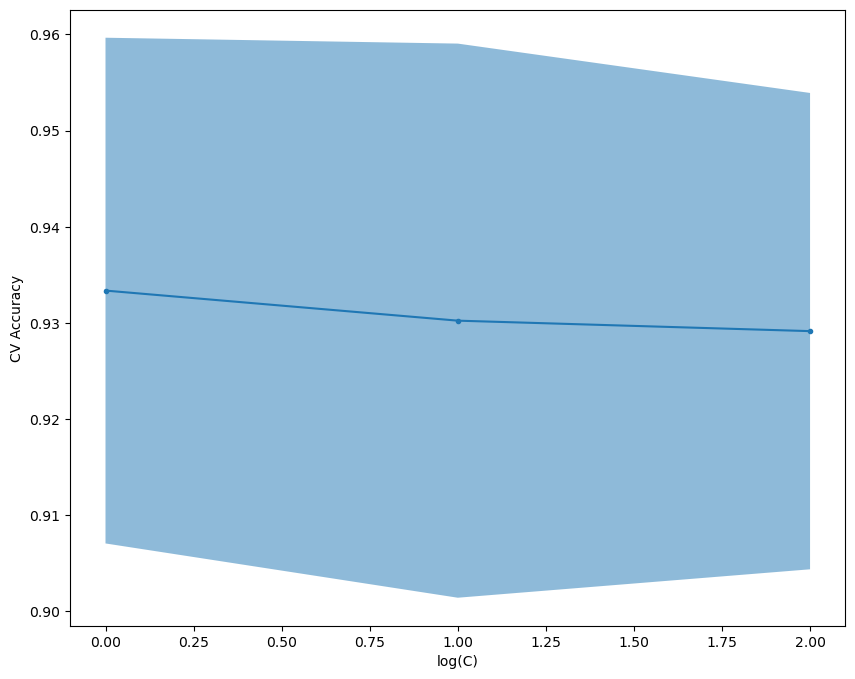

In [68]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

ax.plot(np.log10(lr_results["param_C"]), lr_results["mean_test_score"], marker=".")
ax.fill_between(np.log10(lr_results["param_C"]), lr_results["mean_test_score"] - lr_results["std_test_score"],
                lr_results["mean_test_score"] + lr_results["std_test_score"], alpha=.5)
ax.set_xlabel("log(C)")
ax.set_ylabel("CV Accuracy")

plt.show()

In [69]:
lr_clf_best = lr_cv.best_estimator_
print("Best regressor had C parameter {:.2f} with CV accuracy {:.5f}.".format(lr_cv.best_params_["C"], lr_cv.best_score_))
print("The best test accuracy was {:.5f}".format(lr_clf_best.score(X_test, y_test)))

Best regressor had C parameter 1.00 with CV accuracy 0.93336.
The best test accuracy was 0.95792


Surprisingly, the best model for the classification of activity was a (O-V-R) LogisticRegression model. Below is a small exploration into how the model is operating, and we see in fact that there is linear separability in the classes when considering just two of the features.

However, in every case the ensemble methods did not have a complete search of their hyperparameter space (learning rate for boosting, n_estimators for bagging and random forest). We can see in all 3 graphs that there is a trend of increasing accuracy with increase of these parameters, so given more computing resources we could potentially make these models perform better. Moreover, they don't show strong signs of overfitting since the accuracy does not suffer when measured on the separate test set of data.

But following the principle of Occam's razor, this is not worthwhile, and we should be fairly content with our simple, accurate, and interpretable Logistic Regression model.

In [70]:
lr_clf_best.coef_[0].argsort()

array([ 56,  52,  40,  49, 559,  39,  55, 184, 446, 143, 260, 366, 183,
         9, 152, 103, 447, 553, 236, 287, 234, 367, 288, 157, 552, 536,
       556, 523, 510,   0,  99, 350, 560, 102,  86, 208, 221,  22,  83,
        72,  87, 347, 363, 344, 100,  76,  95, 226, 231, 359, 348, 104,
       182,  84, 520, 515, 353, 351, 517, 289, 229, 285,  79, 227,  23,
       198, 284, 345, 228, 522, 140,  74, 427, 262,  89, 233, 549, 368,
       431, 127, 444, 128, 354, 516, 124, 181, 125, 146, 425, 168, 251,
       141, 271, 165, 179, 433, 428, 265, 266, 430, 280,  70, 518, 448,
       247, 230, 424, 364, 272, 256, 375, 257, 252, 175, 438, 286, 166,
       509, 139, 397, 171,  88, 407, 442, 101, 519, 223, 210,   3, 393,
       346, 325,   4, 404, 434, 154, 360, 167,  96, 180, 352,  85,  90,
       164, 527,   7, 239, 244, 365, 246, 443, 268, 381, 135, 130, 349,
       311,  97, 361, 376,   6, 318, 390, 232, 526, 389, 524, 259, 304,
       355, 163, 445, 521, 394,  32, 121, 317, 269, 383, 403, 12

In [71]:
label_ec_y.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [72]:
activity_train_df.iloc[:,57]

0      -0.970905
1      -0.970583
2      -0.970368
3      -0.969400
4      -0.967051
          ...   
7347   -0.918375
7348   -0.902880
7349   -0.907561
7350   -0.910648
7351   -0.910579
Name: tGravityAcc-energy()-Y, Length: 7352, dtype: float64

/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jhughes2712/miniconda3/envs/mphildis_ads/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

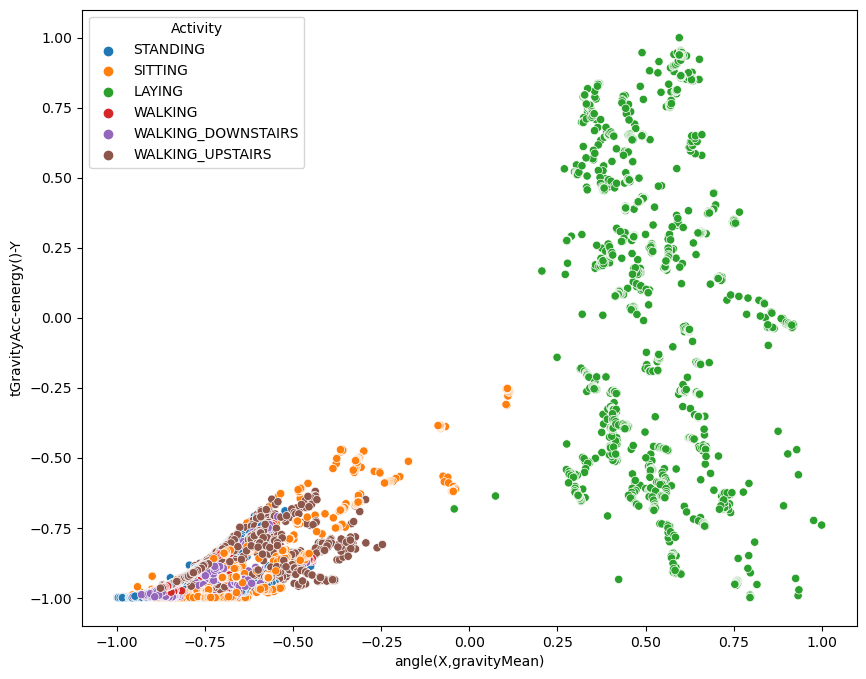

In [73]:
plt.figure(figsize=(10,8))
_ = sns.scatterplot(activity_train_df, x="angle(X,gravityMean)", y="tGravityAcc-energy()-Y", hue="Activity")
plt.show()